In [3]:
import os
import numpy as np
import pandas as pd
import time
from time import time
import datetime
from datetime import datetime
from datetime import timedelta


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import auc, r2_score, mean_squared_error

import csv
import glob
import math
import warnings
import operator
from colorama import Fore, Style
from scipy import stats

In [4]:
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)
pd.set_option("display.max_colwidth",100)
pd.set_option('float_format', '{:.2f}'.format)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [5]:
def feature_stats(df, f, cat_feats):
    if f in cat_feats:
        stats_dict = df[f].value_counts().head(2).to_dict()
        
    elif (df[f].dtype in ['int','float']) & (df[f].nunique() >= 30):
        stats_dict = {'min': np.round(df[f].min(),2), 'max': np.round(df[f].max(),2), 'mean': np.round(df[f].mean(),2), 
                      "median": np.round(df[f].median(),2), "std": np.round(df[f].std(),2)}
    else:
        stats_dict = df[f].value_counts().head(3).to_dict()
    
    return stats_dict

In [6]:
def dataset_view(df, cat_feats=[]):
    print("Number of observations: {}. Number of Features: {}. Number of duplicates: {}.".format(df.shape[0], df.shape[1],
                                                                                                 np.sum(df.duplicated())))
    df_report = pd.DataFrame({"Feature": df.columns})
    
    df_report["Type"] = df_report["Feature"].apply(lambda f: df[f].dtype)
    df_report["NAs Count"] = df_report["Feature"].apply(lambda f: np.sum(df[f].isna()))
    df_report["NAs Percentage"] = df_report["Feature"].apply(lambda f: np.round(np.sum(df[f].isna())*100/len(df[f]), 2))
    df_report["Zeros Count"] = df_report["Feature"].apply(lambda f: np.sum(df[f] == 0))
    df_report["Zeros Percentage"] = df_report["Feature"].apply(lambda f: np.round(np.sum(df[f] == 0)*100/len(df[f]), 2) if df[f].dtype in ['int','float'] else 0)
    
    df_report["Number of Unique"] = df_report["Feature"].apply(lambda f: df[f].nunique())
    df_report["Sample Info"] = df_report["Feature"].apply(lambda f: feature_stats(df,f,cat_feats))    
    return df_report

In [7]:
def plot_cats(df,x,y,title):
    plot = sns.catplot(data=df, x=x,y=y, kind="bar",height=5, aspect=4).set(title=title)
    plot.set_xticklabels(rotation=45);

In [8]:
def detect_outliers(df, z_feats=[], skew_feats=[], other=[], m2=[]):
    outliers_lst = []
    for f in z_feats:
        up_lim = df[f].mean() + 3*df[f].std()
        low_lim = df[f].mean() - 3*df[f].std()
        df_out = df[(df[f] > up_lim) | (df[f] < low_lim)]
        out_n = len(df_out)
        out_p = np.round((out_n/len(df))*100,2)
        outliers_lst.append({"Feature":f, "Upper_Limit": up_lim, "Lower_Limit":low_lim, 
                             "Outier_N":out_n, "Outlier_%":out_p})
    for f in skew_feats:
        Q1 = df[f].quantile(0.25)
        Q3 = df[f].quantile(0.75)
        IQR = Q3-Q1
        scale = 1.5 # used scale 2.5 instead 1.5
        low_lim = Q1 - (scale * IQR) 
        up_lim = Q3 + (scale * IQR)
        df_out = df[(df[f] > up_lim) | (df[f] < low_lim)]
        out_n = len(df_out)
        out_p = np.round((out_n/len(df))*100,2)
        outliers_lst.append({"Feature":f, "Upper_Limit": up_lim, "Lower_Limit":low_lim, 
                             "Outier_N":out_n, "Outlier_%":out_p}) 
    for f in other:
        up_lim = df[f].quantile(0.99)
        low_lim = df[f].quantile(0.01)
        df_out = df[(df[f] > up_lim) | (df[f] < low_lim)]
        out_n = len(df_out)
        out_p = np.round((out_n/len(df))*100,2)
        outliers_lst.append({"Feature":f, "Upper_Limit": up_lim, "Lower_Limit":low_lim, 
                             "Outier_N":out_n, "Outlier_%":out_p})
        
    for f in m2:
        Q1 = df[f].quantile(0.25)
        Q3 = df[f].quantile(0.75)
        IQR = Q3-Q1
        scale = 2.5 
        low_lim = max((Q1 - (scale * IQR)),0)
        up_lim = Q3 + (scale * IQR)
        df_out = df[(df[f] > up_lim) | (df[f] < low_lim)]
        out_n = len(df_out)
        out_p = np.round((out_n/len(df))*100,2)
        outliers_lst.append({"Feature":f, "Upper_Limit": up_lim, "Lower_Limit":low_lim, 
                             "Outier_N":out_n, "Outlier_%":out_p}) 

    return outliers_lst

In [9]:
def plot_outliers(df, df_out):
    a = 8
    b = 2
    c = 1
    fig = plt.figure(figsize = (20,20))
    for col in df.columns[1:]:
        
        low_lim = float(df_out.loc[df_out["Feature"] == col,"Lower_Limit"])
        up_lim = float(df_out.loc[df_out["Feature"] == col,"Upper_Limit"])
        df_filter = df[(df[col] > up_lim) | (df[col] < low_lim)]
        df_ok = df[~df.index.isin(df_filter.index)]
        
        x_ok = df_ok["Timestamp"]
        y_ok = df_ok[col]
        x = df_filter["Timestamp"]
        y = df_filter[col]
        
        plt.subplot(a,b,c)
        plt.title('{}'.format(col))
        plt.plot(x,y,'r.',x_ok,y_ok,"k.")
        plt.axhline(y = up_lim, color = 'red')
        plt.axhline(y = low_lim, color = 'red')
        c=c+1
    fig.tight_layout()

In [10]:
def pheno_model(df, JB_real):
    Cp = '%_Solids' #Solidos (%)
    Potencia = 'Power (kw)' #Potencia (kW)
    velocidad = 'SAG_Velocity (RPM)' #Velocidad (RPM)
    presion_a = 'Avg_Loading_Pressure_SAG' #Presion (KPa) se transforman en kg/cm2 en las ecuaciones
    presion_d = 'Avg_Unloading_Pressure_SAG' #Presion KPa
    presion = 'Pressure' #Presion KPa
    presion_lh = 'PressureLH'


    d_mol = 11.67 #(m) Diametro en metros se transforman en ft en las ecuaciones
    L = 6.7 #Longitud en metros se transfo!rman en ft en las ecuaciones

    d_min = 2.7 #(g/cc3) Densidad Mineral pasar a t/m3 (1=1)
    d_bol = 7.85 #(g/cc3) Desidad Bolas pasar a t/m3 (1=1)

    jc_ideal = 28
    m_JC = [0.3333, 1.2]
    Jfill = 0.6
    
    dataset_h = df.copy()

    var=[Cp, Potencia, velocidad, presion_a, presion_d]
    for var1 in dataset_h[var]:
        print(dataset_h[var1].name)
        print(dataset_h[var1].count()*100/len(dataset_h))

    dataset_h[presion] = (dataset_h[presion_a] + dataset_h[presion_d]) / 2

    dataset_h['Ro_pulpa'] = 1 / (dataset_h[Cp] / d_min / 100 + (1-dataset_h[Cp] / 100))
    dataset_h['Nc'] = abs(dataset_h[velocidad]) / 76.6 * math.sqrt(d_mol * 3.28) * 100
    roap = (0.6*d_bol*np.nanmean(JB_real)/100 + 0.6*d_min*(jc_ideal/100 - np.nanmean(JB_real)/100) + dataset_h['Ro_pulpa'].mean()*jc_ideal/100*0.4*Jfill)/(jc_ideal/100)
    alpha = np.arcsin((dataset_h[Potencia].mean()*0.9)/(0.238*((d_mol*3.28)**2.5)*L*3.28*dataset_h['Nc'].mean()/100*roap*((jc_ideal/100)-1.065*((jc_ideal/100)**2))))*180/np.pi

    for i in range(len(m_JC)):
        dataset_h['bt'+str(i)] = jc_ideal - m_JC[i] * dataset_h[presion_lh]/98.066
        dataset_h['JC'+str(i)] = m_JC[i] * dataset_h[presion]/98.066 + dataset_h['bt'+str(i)] 
        dataset_h['cte'+str(i)] = 0.238* (d_mol*3.28)**(2.5)* L *3.28 *dataset_h['JC'+str(i)]/100 * (1-1.065*dataset_h['JC'+str(i)] /100) * dataset_h['Nc'] / 100*math.sin(alpha/180*math.pi)
        dataset_h['cte'+str(i)] = np.where((dataset_h['cte'+str(i)]>100), dataset_h['cte'+str(i)], np.nan)
        dataset_h['Ro_ap'+str(i)] = dataset_h[Potencia] * 0.9 / dataset_h['cte'+str(i)]
        dataset_h['cte1'+str(i)] = (dataset_h['JC'+str(i)] / 100*dataset_h['Ro_ap'+str(i)] - dataset_h['Ro_pulpa'] * (dataset_h['JC'+str(i)]/100*0.4) *Jfill) / 0.6/ (d_bol - d_min)
        dataset_h['cte2'+str(i)]= 2.8 * dataset_h['JC'+str(i)]/100 / (d_bol - d_min)
        dataset_h['JB'+str(i)] = np.where(dataset_h['cte'+str(i)]>100, dataset_h['cte1'+str(i)]-dataset_h['cte2'+str(i)], np.nan)
        dataset_h['JB'+str(i)] = np.where((dataset_h['JB'+str(i)]>0.08), dataset_h['JB'+str(i)], np.nan)
    
    df["JB0"] = dataset_h["JB0"]*100
    df["JB1"] = dataset_h["JB1"]*100
    return df

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
null_values = ["Intf Shut","Out of Serv","I/O Timeout","Bad","Scan Timeout","Calc Failed"]
df_data = pd.read_csv('DatosProm20-21_E.csv',sep=';',na_values=null_values,parse_dates=[0])

In [13]:
df_average = df_data

In [14]:
df_data.head()

,Tiempo,MB1 Velocidad,MB1 Potencia,MB1 Torque,MB1 Peso,N1 Flujo,N1 Presion,N1 Ciclones On,N1 Densidad,N1 Sensor z,N1 Nivel,Relave Nivel,FLO Pot 1,FLO Pot 9,FLO Pot 17,SUL Nivel,SUL Agua,SAG Faja 5,SAG Solidos,SAG Faja 15,SAG Faja 11,SAG Velocidad,SAG Potencia,SAG Corriente,IMP Sensor 1,IMP Sensor 2,IMP Sensor 3,IMP Sensor 4,PSM1 L1
0,2020-01-01 00:00:00,12.00,15223.00,12112.01,2421.72,8133.13,93.46,9.00,1703.80,47.50,72.46,31.68,232.40,235.39,153.40,69.90,3395.54,3917.85,73.10,816.43,562.70,-8.98,21291.70,3504.12,0.00,0.00,0.00,0.00,281.47
1,2020-01-01 00:05:00,12.00,15220.91,12109.65,2419.37,8089.53,92.96,9.00,1705.46,47.41,72.08,31.59,234.83,241.49,159.58,67.87,3397.59,3893.52,73.04,831.49,577.84,-8.98,21345.47,3515.60,0.00,0.00,0.00,0.00,288.84
2,2020-01-01 00:10:00,11.99,15207.79,12099.65,2421.28,8143.08,95.14,9.00,1703.48,47.15,72.87,31.71,228.45,238.11,159.70,69.96,3399.98,3897.76,73.07,829.65,562.93,-8.97,21372.54,3524.60,0.00,0.00,0.00,0.00,281.06
3,2020-01-01 00:15:00,11.99,15207.59,12099.52,2421.19,8237.62,97.00,9.00,1697.75,46.58,73.87,31.70,231.01,228.54,157.43,74.53,3403.03,3902.20,73.02,827.26,554.85,-8.98,21448.01,3532.43,0.00,0.00,0.00,0.00,278.48
4,2020-01-01 00:20:00,12.00,15210.13,12103.42,2420.98,8255.28,97.18,9.00,1698.61,46.79,73.86,30.71,228.87,237.16,157.88,78.72,3397.44,3900.93,73.04,823.71,567.25,-9.01,21498.30,3528.92,0.00,0.00,0.00,0.00,275.87


In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192673 entries, 0 to 192672
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Tiempo          192673 non-null  datetime64[ns]
 1   MB1 Velocidad   191445 non-null  float64       
 2   MB1 Potencia    191445 non-null  float64       
 3   MB1 Torque      191445 non-null  float64       
 4   MB1 Peso        191530 non-null  float64       
 5   N1 Flujo        183750 non-null  float64       
 6   N1 Presion      191315 non-null  float64       
 7   N1 Ciclones On  191577 non-null  float64       
 8   N1 Densidad     184944 non-null  float64       
 9   N1 Sensor z     191645 non-null  float64       
 10  N1 Nivel        190636 non-null  float64       
 11  Relave Nivel    191476 non-null  float64       
 12  FLO Pot 1       190718 non-null  float64       
 13  FLO Pot 9       190888 non-null  float64       
 14  FLO Pot 17      191628 non-null  flo

In [17]:
df_temp = dataset_view(df_data)
df_temp

Number of observations: 192673. Number of Features: 29. Number of duplicates: 0.


,Feature,Type,NAs Count,NAs Percentage,Zeros Count,Zeros Percentage,Number of Unique,Sample Info
0,Tiempo,datetime64[ns],0,0.00,0,0.00,192673,"{2020-01-01 00:00:00: 1, 2021-03-22 00:20:00: 1, 2021-03-21 23:35:00: 1}"
1,MB1 Velocidad,float64,1228,0.64,7290,3.78,718,"{'min': -0.12, 'max': 12.0, 'mean': 11.27, 'median': 11.82, 'std': 2.38}"
2,MB1 Potencia,float64,1228,0.64,6857,3.56,90079,"{'min': -38.72, 'max': 16373.47, 'mean': 14646.54, 'median': 15441.86, 'std': 3135.97}"
3,MB1 Torque,float64,1228,0.64,6854,3.56,81987,"{'min': -4027.9, 'max': 13647.08, 'mean': 11905.0, 'median': 12443.21, 'std': 2417.37}"
4,MB1 Peso,float64,1143,0.59,0,0.00,42075,"{'min': 1315.09, 'max': 2706.73, 'mean': 2448.49, 'median': 2454.35, 'std': 119.79}"
5,N1 Flujo,float64,8923,4.63,1,0.00,143082,"{'min': 0.0, 'max': 12427.55, 'mean': 8314.59, 'median': 8249.78, 'std': 1102.39}"
6,N1 Presion,float64,1358,0.70,21,0.01,6231,"{'min': -1.49, 'max': 194.19, 'mean': 90.48, 'median': 94.5, 'std': 19.31}"
7,N1 Ciclones On,float64,1096,0.57,457,0.24,877,"{'min': 0.0, 'max': 13.0, 'mean': 9.2, 'median': 9.0, 'std': 1.32}"
8,N1 Densidad,float64,7729,4.01,0,0.00,26756,"{'min': 900.0, 'max': 2100.0, 'mean': 1722.74, 'median': 1729.01, 'std': 76.97}"
9,N1 Sensor z,float64,1028,0.53,6,0.00,5369,"{'min': -14.35, 'max': 68.35, 'mean': 45.25, 'median': 46.95, 'std': 8.23}"


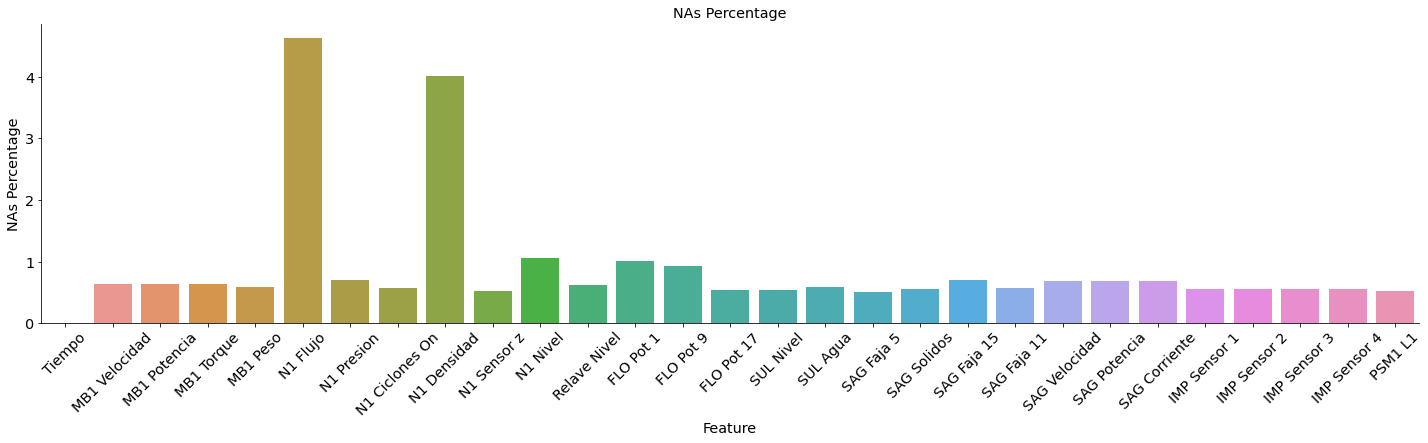

In [18]:
plot_cats(df_temp,"Feature","NAs Percentage","NAs Percentage")

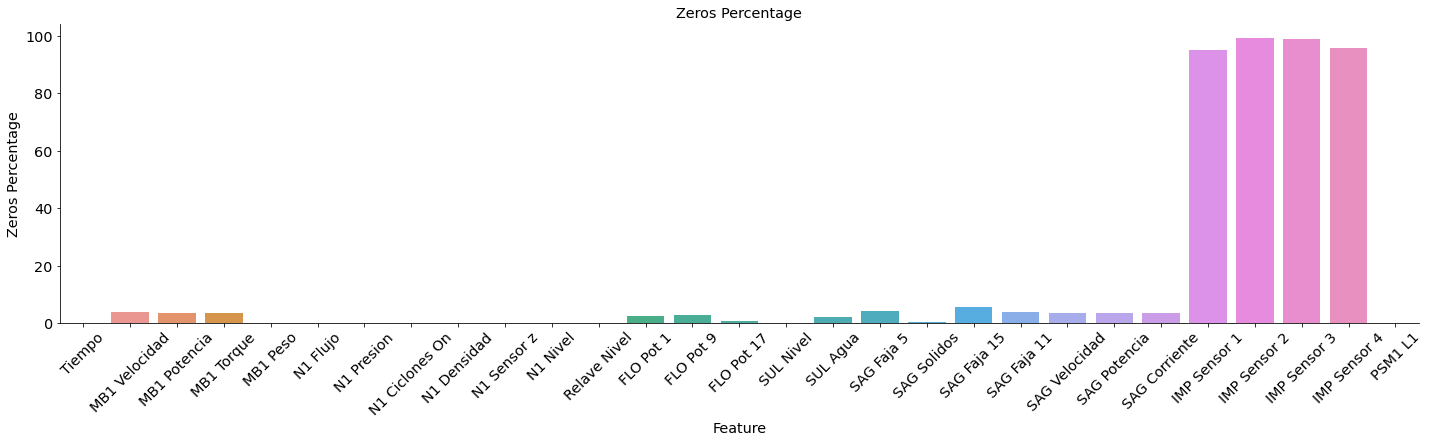

In [19]:
plot_cats(df_temp,"Feature","Zeros Percentage","Zeros Percentage")

In [20]:
df_data.dropna(axis=0, inplace=True)

In [21]:
df_temp = dataset_view(df_data)
df_temp

Number of observations: 183051. Number of Features: 29. Number of duplicates: 0.


,Feature,Type,NAs Count,NAs Percentage,Zeros Count,Zeros Percentage,Number of Unique,Sample Info
0,Tiempo,datetime64[ns],0,0.00,0,0.00,183051,"{2020-01-01 00:00:00: 1, 2021-03-24 08:30:00: 1, 2021-03-24 06:50:00: 1}"
1,MB1 Velocidad,float64,0,0.00,92,0.05,587,"{'min': 0.0, 'max': 12.0, 'mean': 11.74, 'median': 11.84, 'std': 0.69}"
2,MB1 Potencia,float64,0,0.00,29,0.02,88687,"{'min': -16.89, 'max': 16373.47, 'mean': 15259.27, 'median': 15456.03, 'std': 1027.43}"
3,MB1 Torque,float64,0,0.00,29,0.02,80743,"{'min': -2465.98, 'max': 13571.02, 'mean': 12384.13, 'median': 12454.44, 'std': 481.64}"
4,MB1 Peso,float64,0,0.00,0,0.00,36973,"{'min': 1914.18, 'max': 2706.73, 'mean': 2466.73, 'median': 2458.11, 'std': 82.05}"
5,N1 Flujo,float64,0,0.00,0,0.00,142516,"{'min': 1496.26, 'max': 12427.55, 'mean': 8326.48, 'median': 8252.19, 'std': 1073.59}"
6,N1 Presion,float64,0,0.00,0,0.00,5512,"{'min': 0.2, 'max': 194.19, 'mean': 94.14, 'median': 94.81, 'std': 7.65}"
7,N1 Ciclones On,float64,0,0.00,0,0.00,742,"{'min': 2.0, 'max': 13.0, 'mean': 9.24, 'median': 9.0, 'std': 0.93}"
8,N1 Densidad,float64,0,0.00,0,0.00,26511,"{'min': 900.14, 'max': 2100.0, 'mean': 1726.86, 'median': 1729.63, 'std': 62.48}"
9,N1 Sensor z,float64,0,0.00,0,0.00,3594,"{'min': -14.35, 'max': 68.35, 'mean': 46.77, 'median': 47.04, 'std': 3.36}"


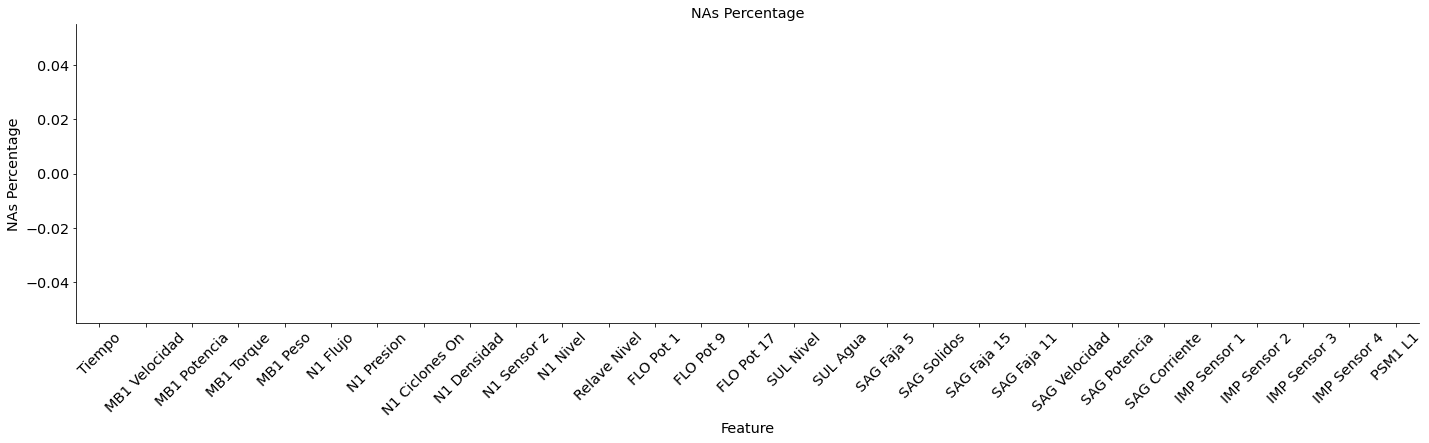

In [22]:
plot_cats(df_temp,"Feature","NAs Percentage","NAs Percentage")

In [23]:
# Velocidad molino 1
df_data = df_data[(df_data['MB1 Velocidad'] > 9)]

#Presión Limites
df_data = df_data[(df_data['N1 Presion'] > 85)]

#Densidad Limites
df_data = df_data[(df_data['N1 Densidad'] > 1650)] 

#P80 limites
df_data = df_data[(df_data['PSM1 L1'] > 200)] 

# #ciclones limites
df_data = df_data[(df_data['N1 Ciclones On'] >= 7)] 


#Flujo Limites
df_data = df_data[(df_data['N1 Flujo'] >= 6300)] 

#Faja 15
df_data = df_data[(df_data['SAG Faja 15'] >= 100)] 

# Nivel SUL80 Limites
df_data = df_data[(df_data['SUL Nivel'] >= 50)
                                    & (df_data['SUL Nivel'] <= 105)]

# Velocidad ABS
df_data['SAG Velocidad'] = df_data['SAG Velocidad'].abs()

Number of observations: 135972. Number of Features: 29. Number of duplicates: 0.


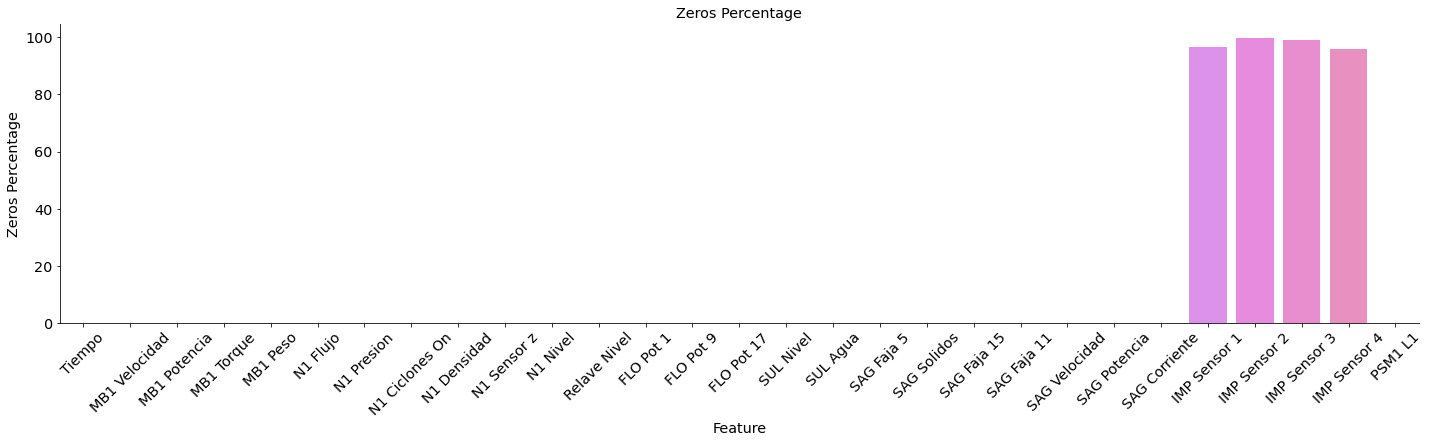

In [24]:
df_temp = dataset_view(df_data)
plot_cats(df_temp,"Feature","Zeros Percentage","Zeros Percentage")

In [25]:
df_data["Mill_Normal"] = True

In [26]:
df_data.loc[(df_data["SAG Potencia"] < 14000) | (np.abs(df_data["SAG Velocidad"]) < 7.5),"Mill_Normal"] = False


In [27]:
def plot_dists(df, feature):
    f, (ax_time, ax_box, ax_hist) = plt.subplots(1,3, sharex=False, figsize=(25,5))
    sns.lineplot(x=df["Tiempo"], y=df[feature], ax=ax_time)
    sns.boxplot(df[feature], ax=ax_box)
    sns.distplot(df[feature], ax=ax_hist)
    f.suptitle(f"{feature} Distribution", fontsize="large");


In [29]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135972 entries, 0 to 192672
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Tiempo          135972 non-null  datetime64[ns]
 1   MB1 Velocidad   135972 non-null  float64       
 2   MB1 Potencia    135972 non-null  float64       
 3   MB1 Torque      135972 non-null  float64       
 4   MB1 Peso        135972 non-null  float64       
 5   N1 Flujo        135972 non-null  float64       
 6   N1 Presion      135972 non-null  float64       
 7   N1 Ciclones On  135972 non-null  float64       
 8   N1 Densidad     135972 non-null  float64       
 9   N1 Sensor z     135972 non-null  float64       
 10  N1 Nivel        135972 non-null  float64       
 11  Relave Nivel    135972 non-null  float64       
 12  FLO Pot 1       135972 non-null  float64       
 13  FLO Pot 9       135972 non-null  float64       
 14  FLO Pot 17      135972 non-null  flo

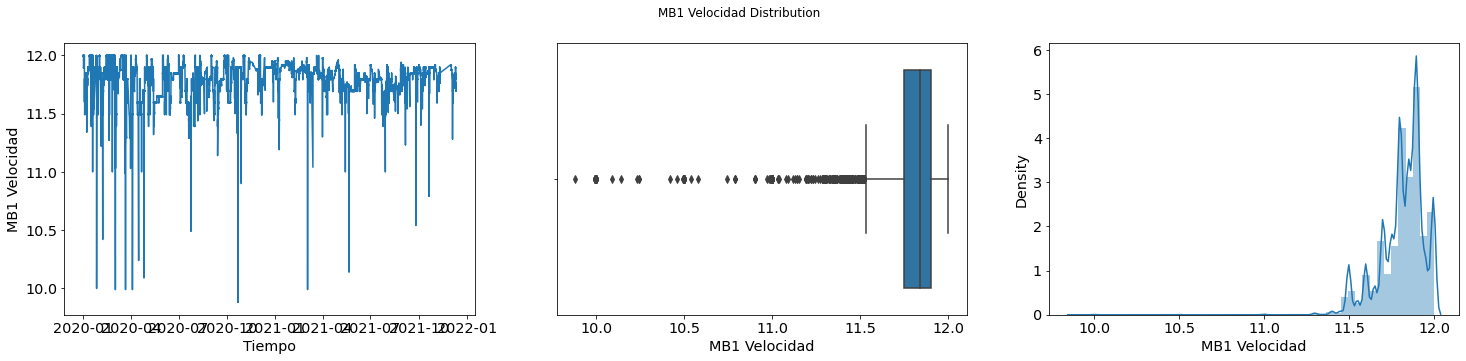

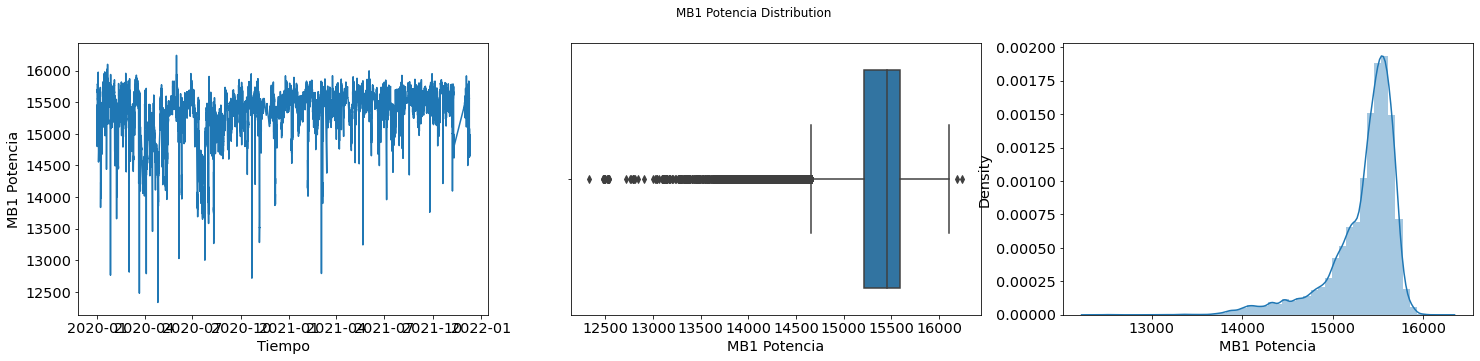

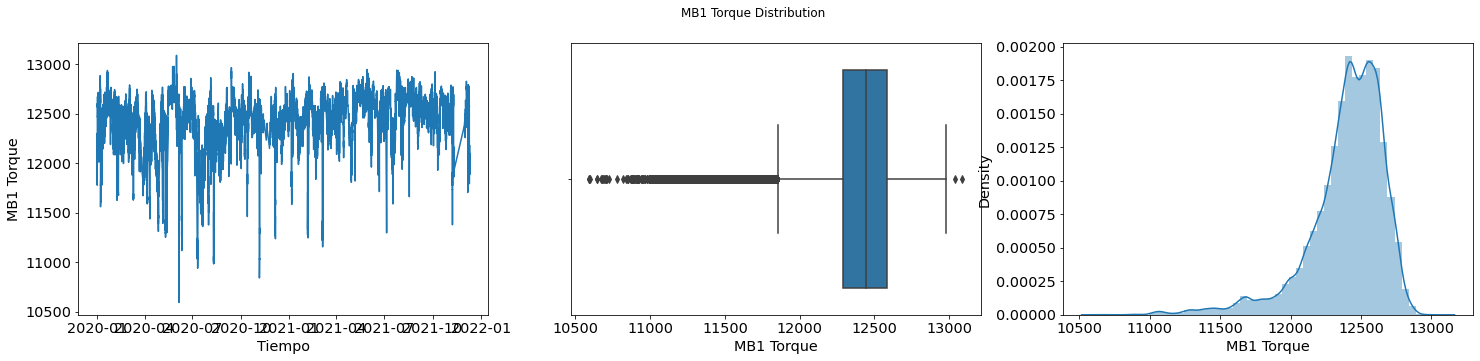

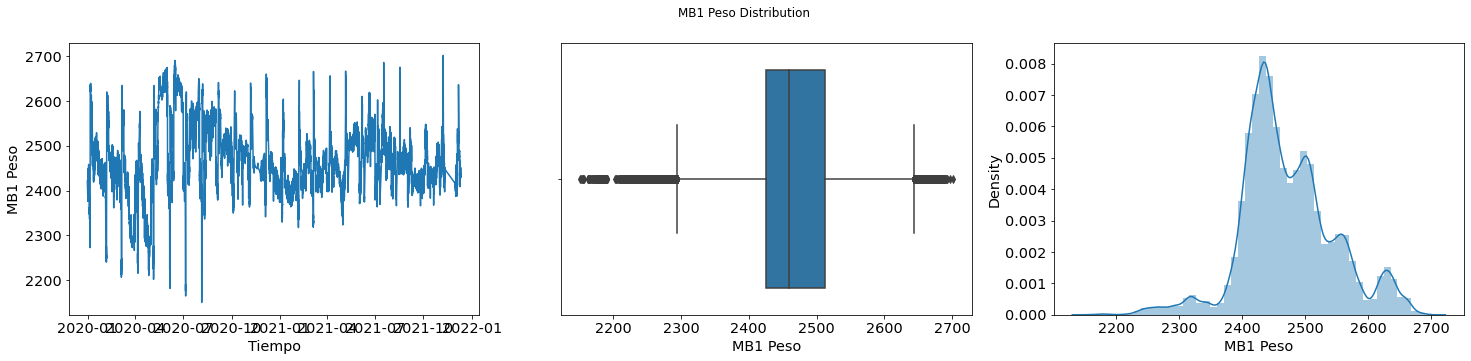

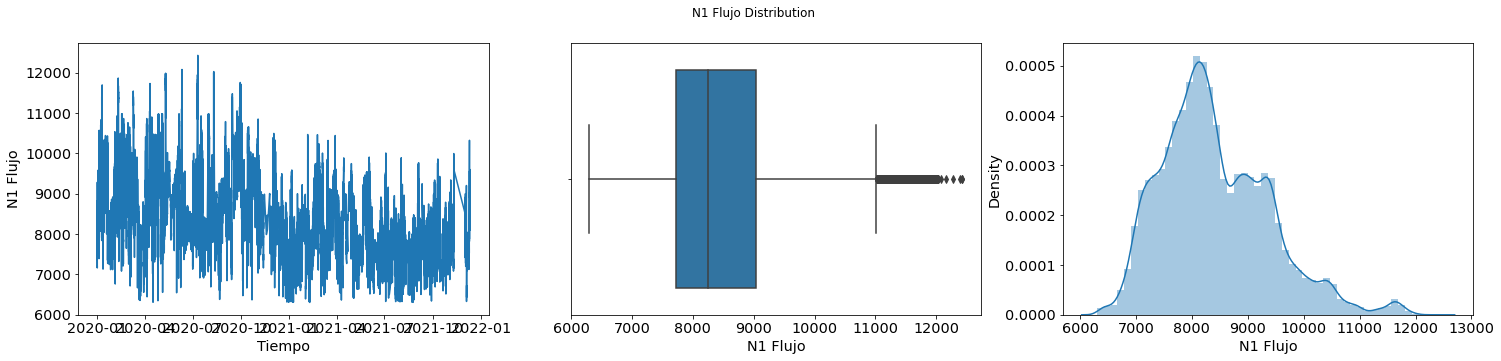

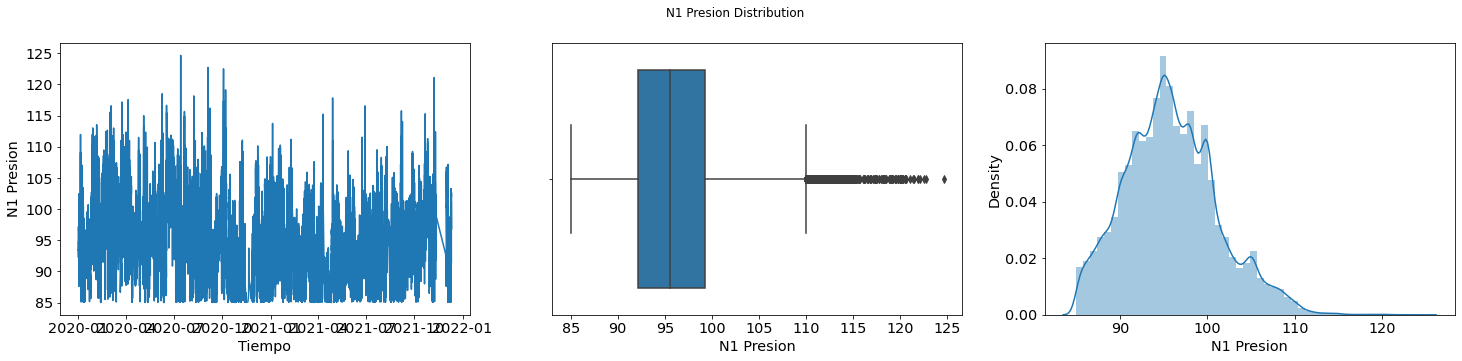

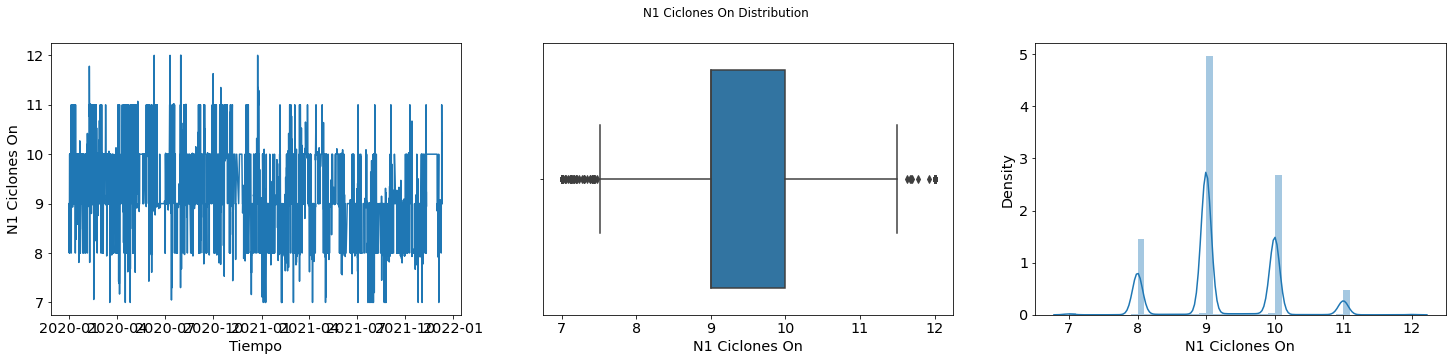

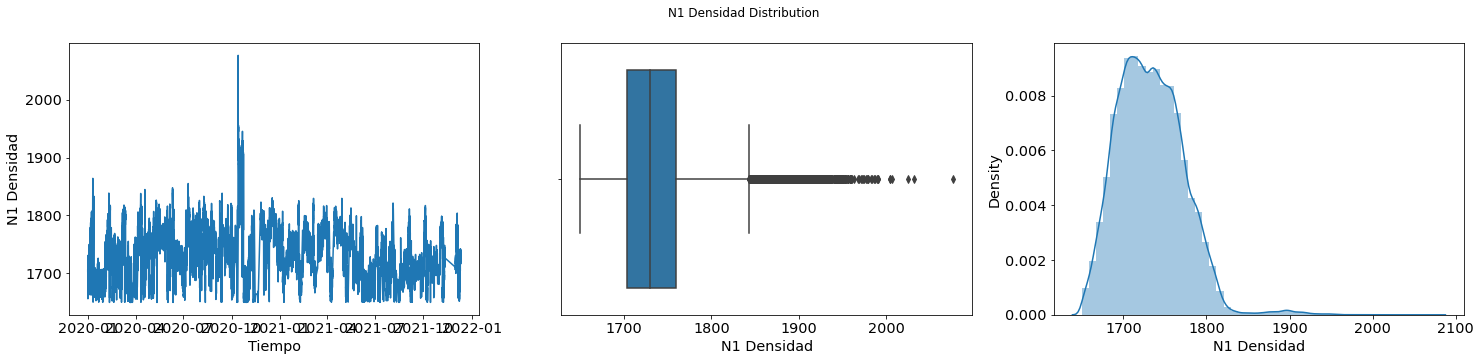

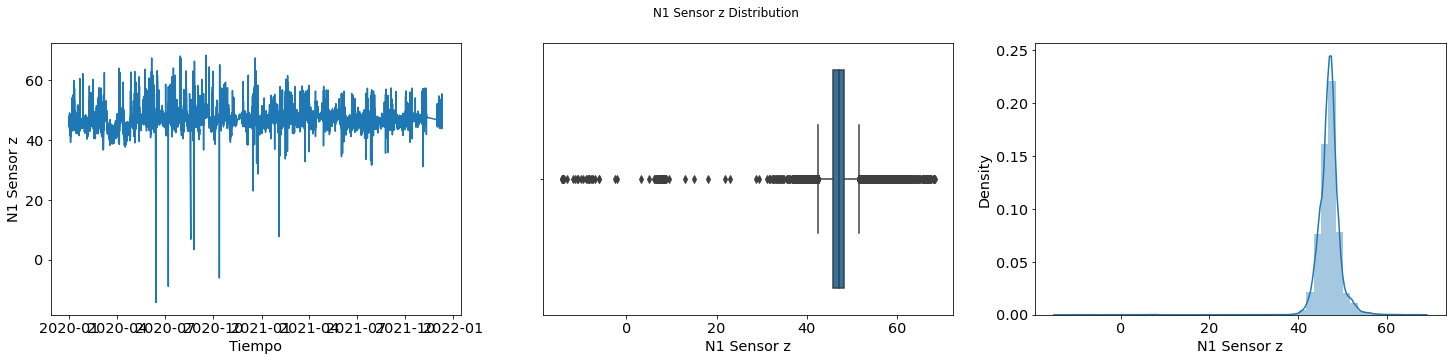

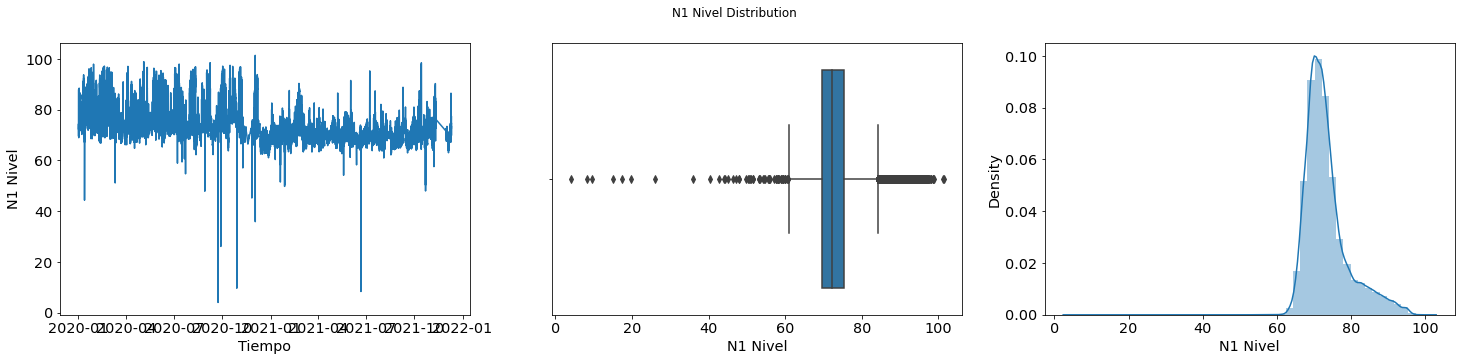

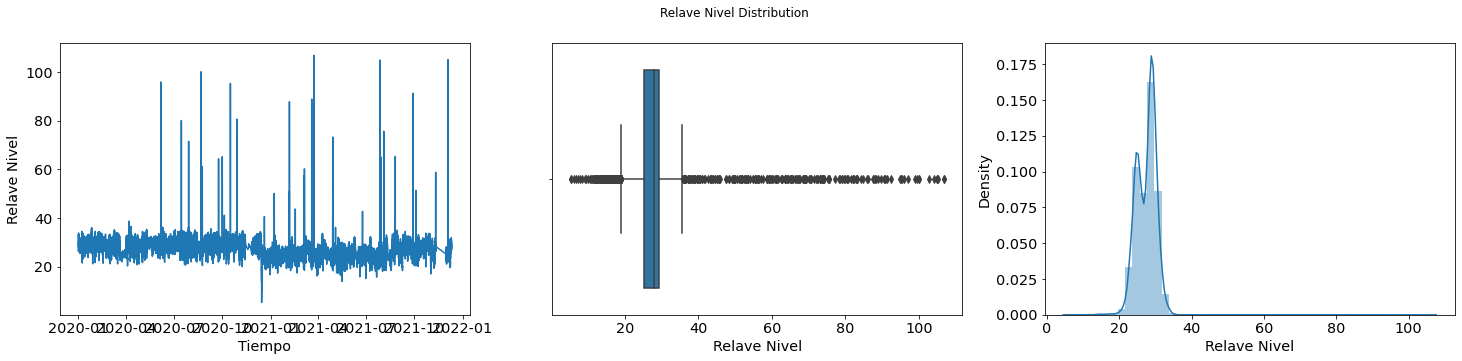

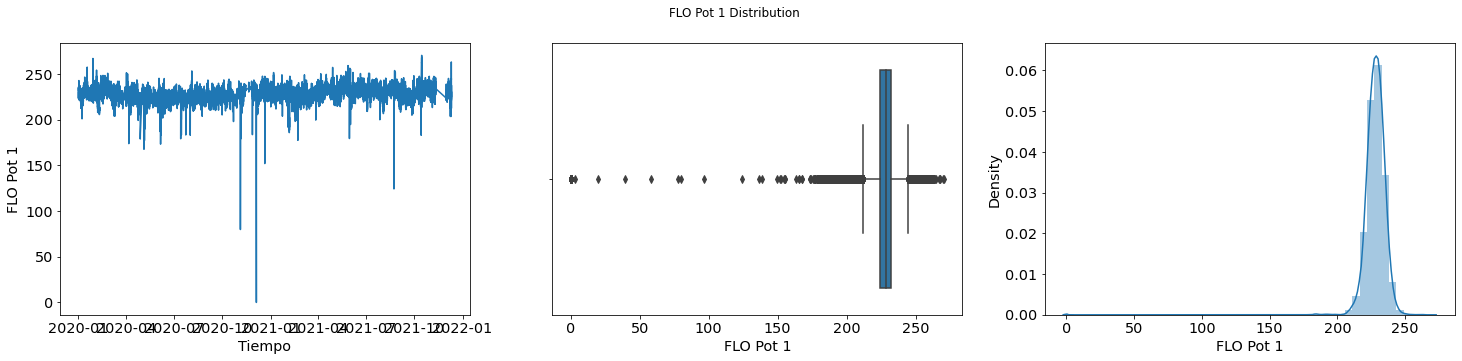

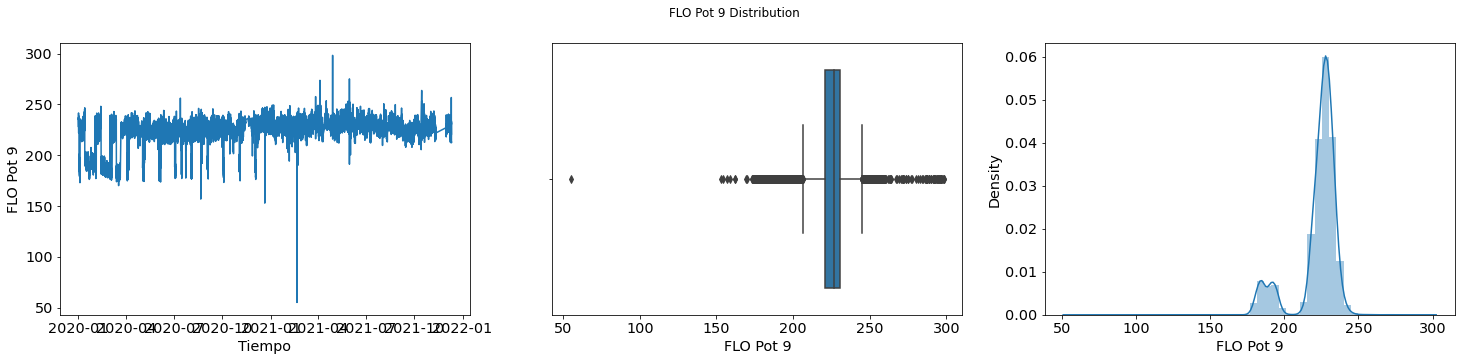

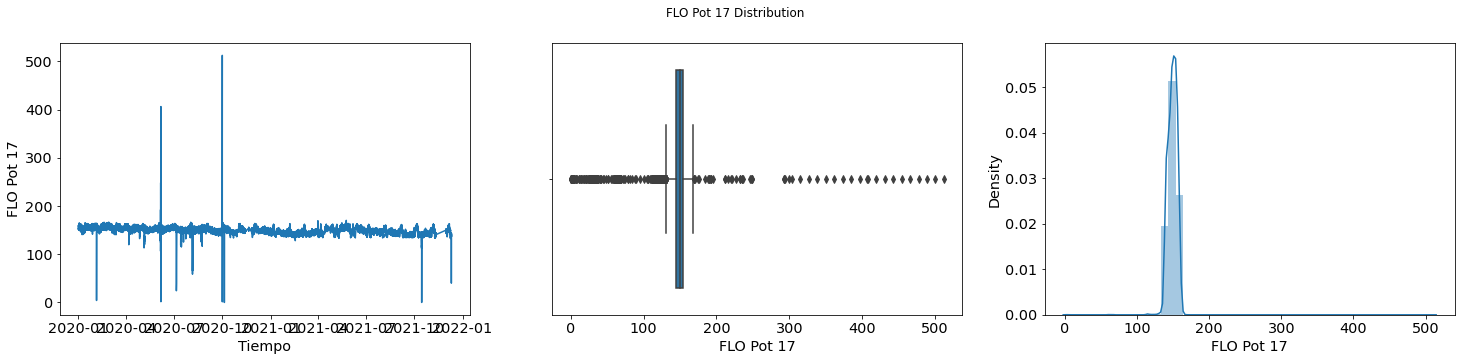

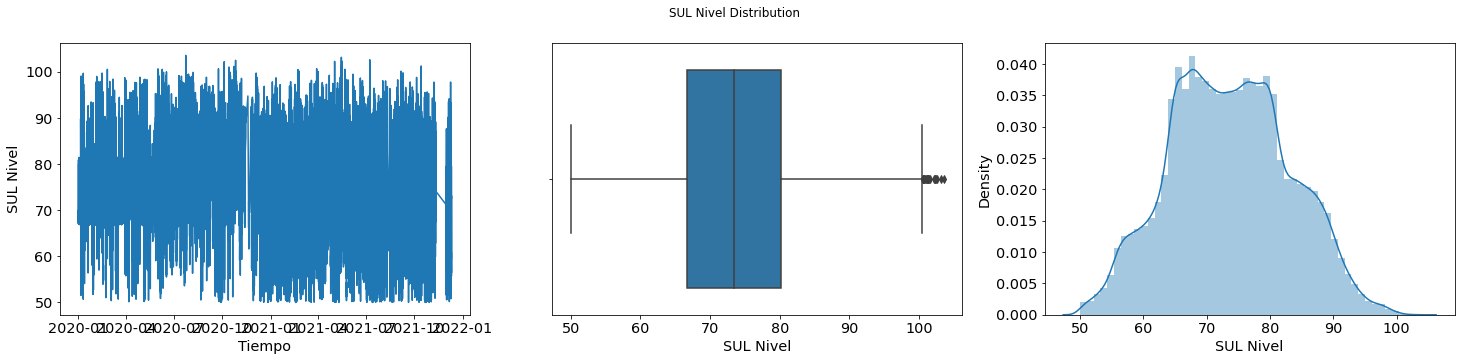

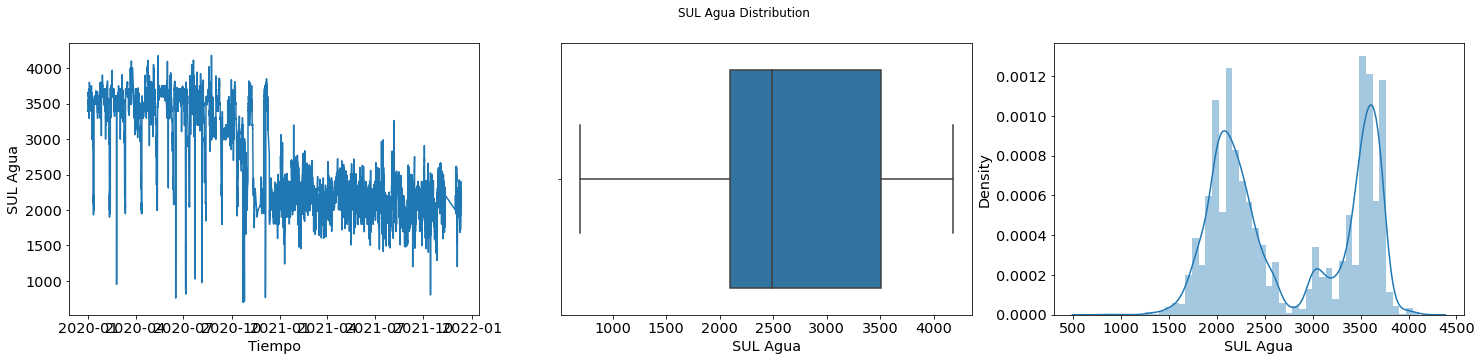

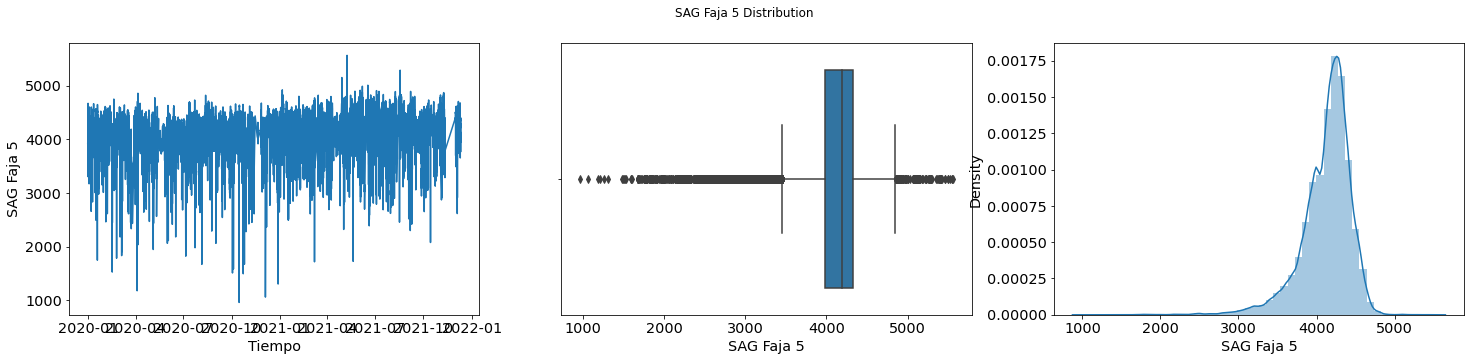

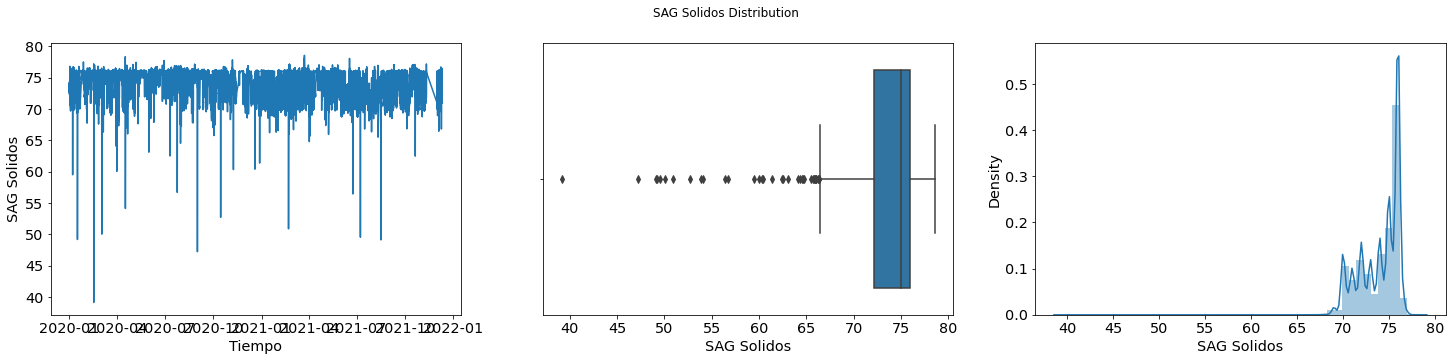

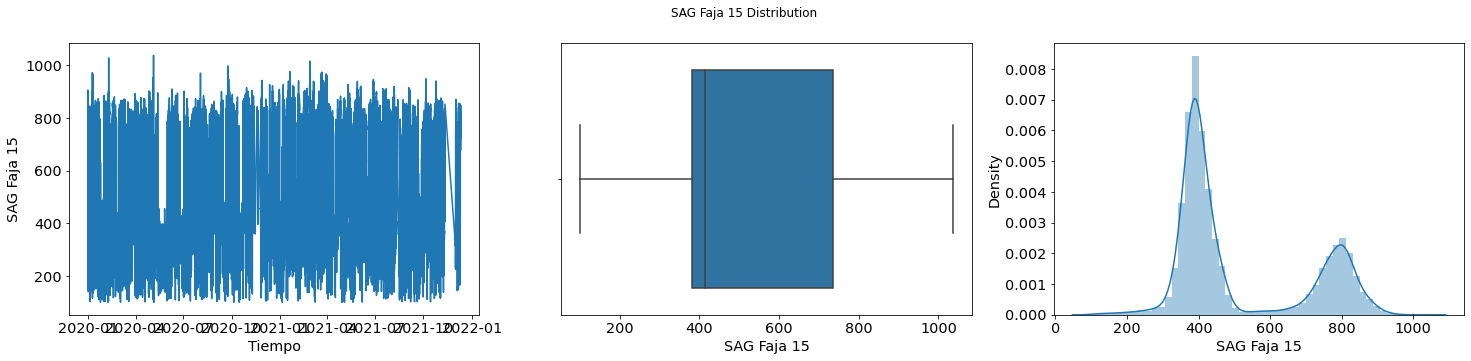

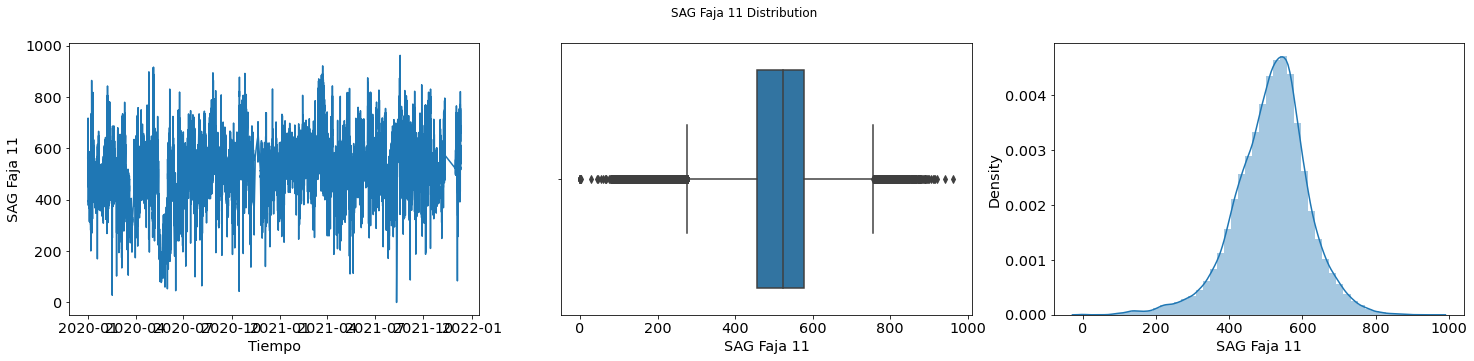

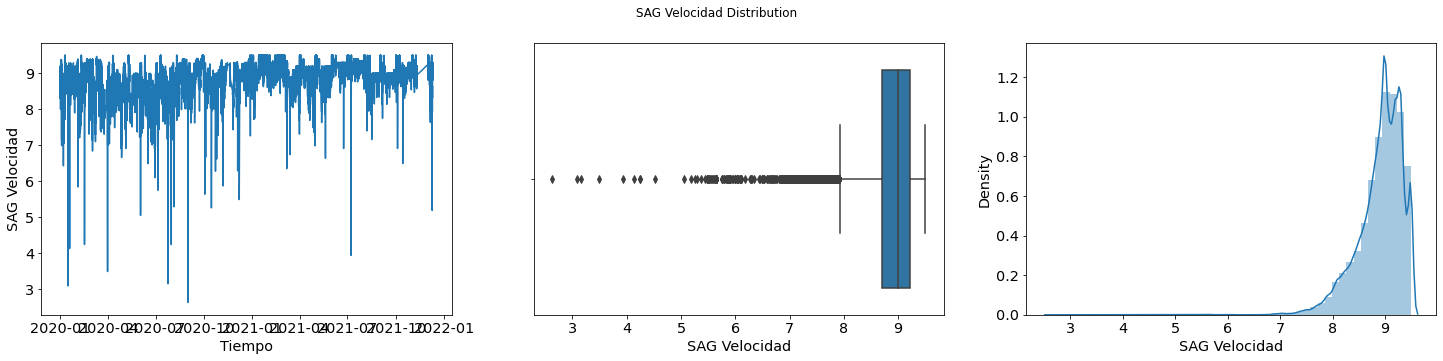

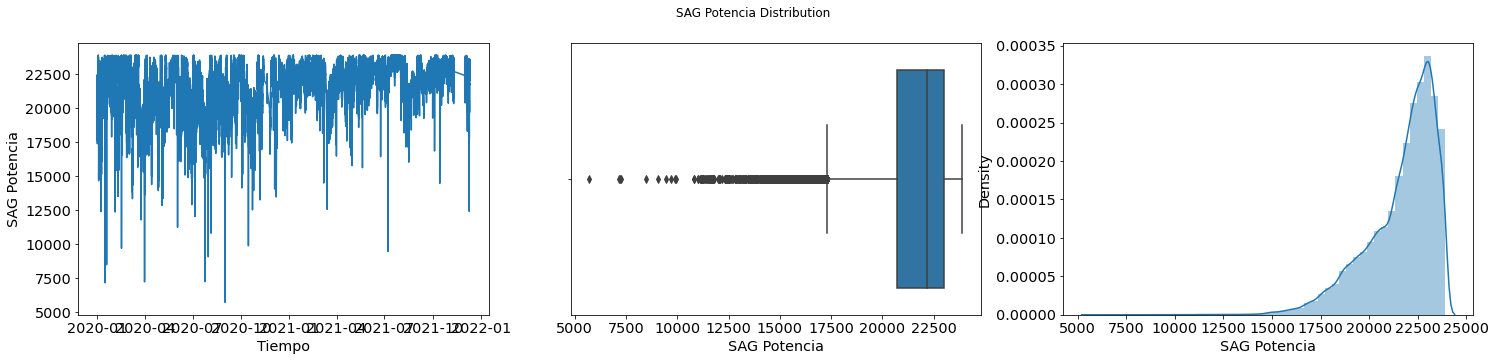

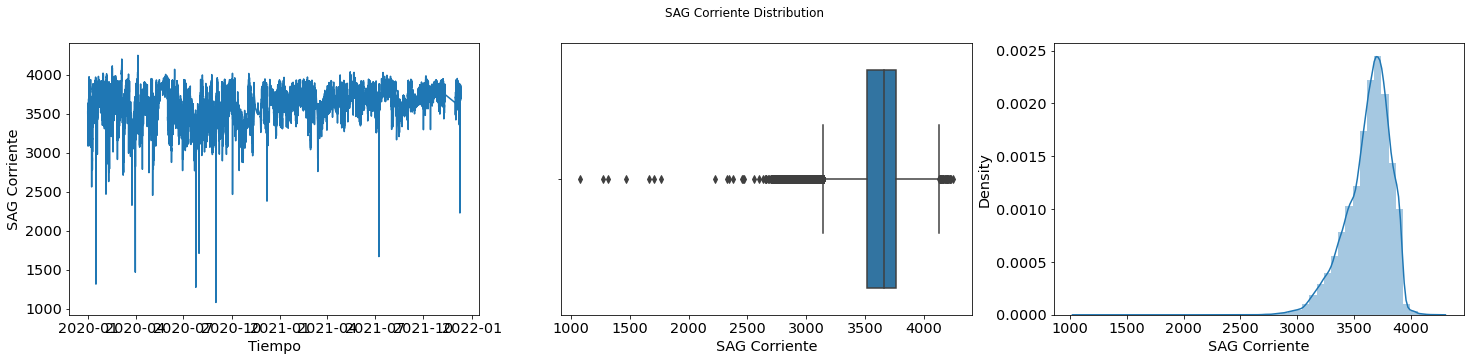

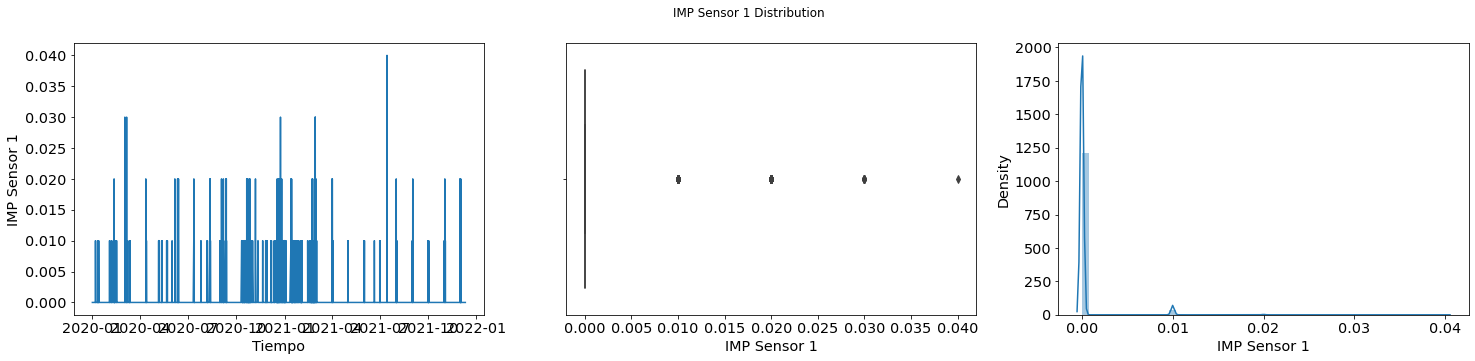

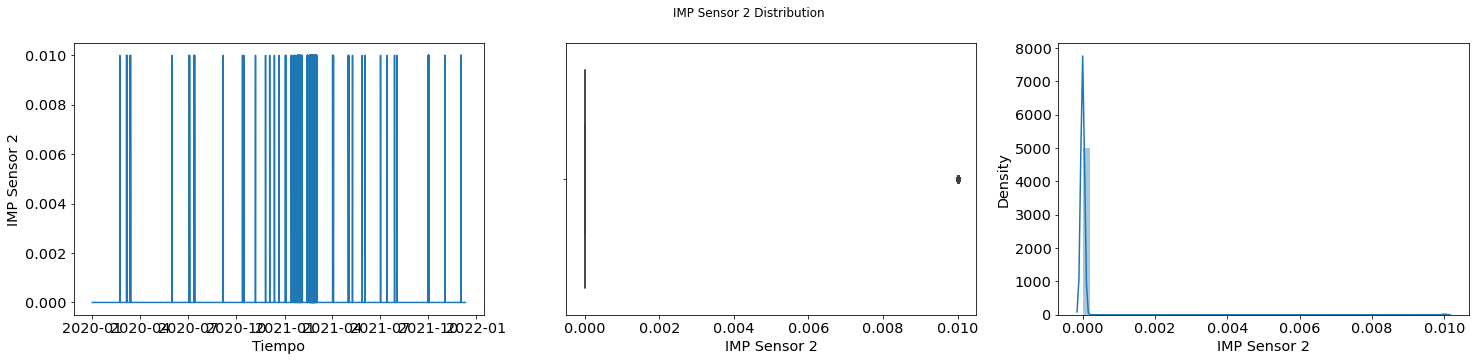

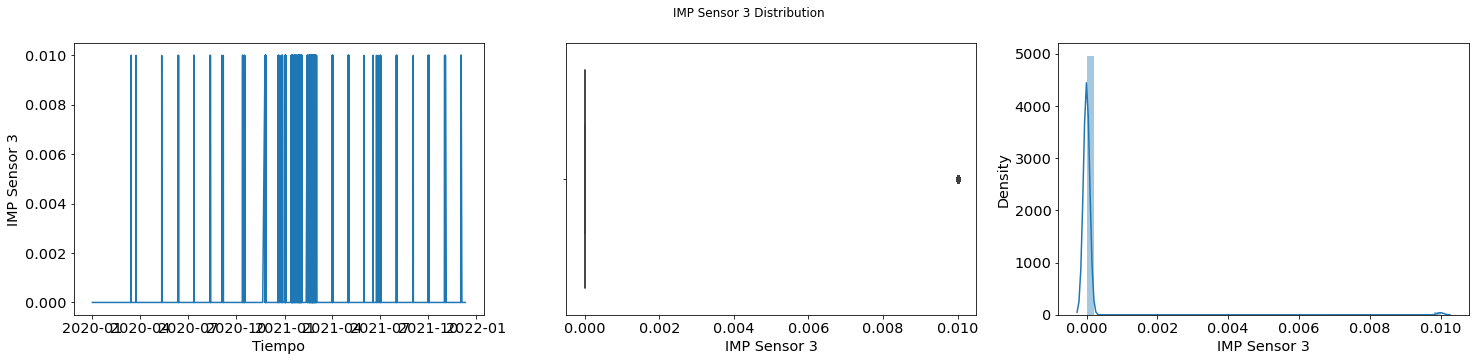

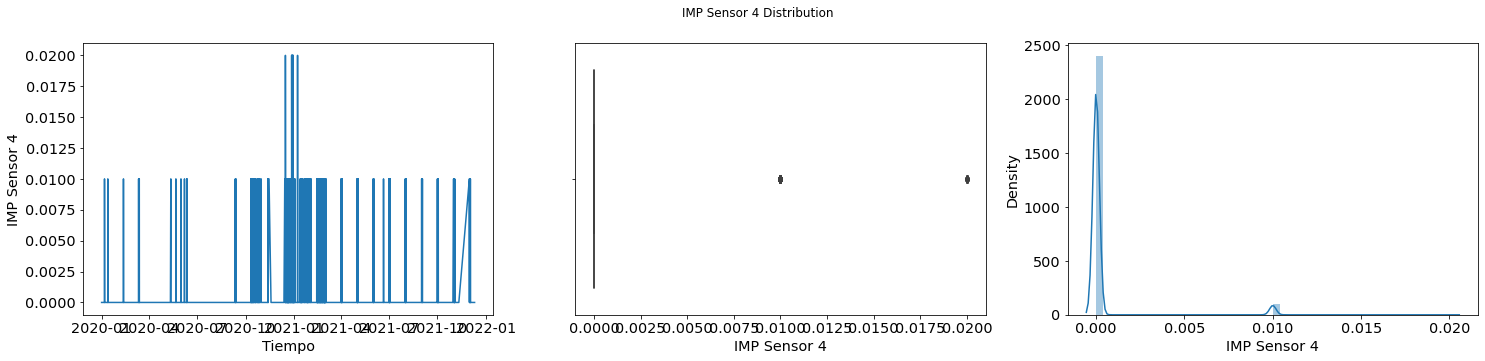

In [30]:
for col in df_data.columns[1:28]:
    plot_dists(df_data, col)

In [31]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135972 entries, 0 to 192672
Data columns (total 30 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Tiempo          135972 non-null  datetime64[ns]
 1   MB1 Velocidad   135972 non-null  float64       
 2   MB1 Potencia    135972 non-null  float64       
 3   MB1 Torque      135972 non-null  float64       
 4   MB1 Peso        135972 non-null  float64       
 5   N1 Flujo        135972 non-null  float64       
 6   N1 Presion      135972 non-null  float64       
 7   N1 Ciclones On  135972 non-null  float64       
 8   N1 Densidad     135972 non-null  float64       
 9   N1 Sensor z     135972 non-null  float64       
 10  N1 Nivel        135972 non-null  float64       
 11  Relave Nivel    135972 non-null  float64       
 12  FLO Pot 1       135972 non-null  float64       
 13  FLO Pot 9       135972 non-null  float64       
 14  FLO Pot 17      135972 non-null  flo

In [63]:
def plot_corr(df,title, fig_size=(20,20)):
    plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot = True)
    plt.title(title);

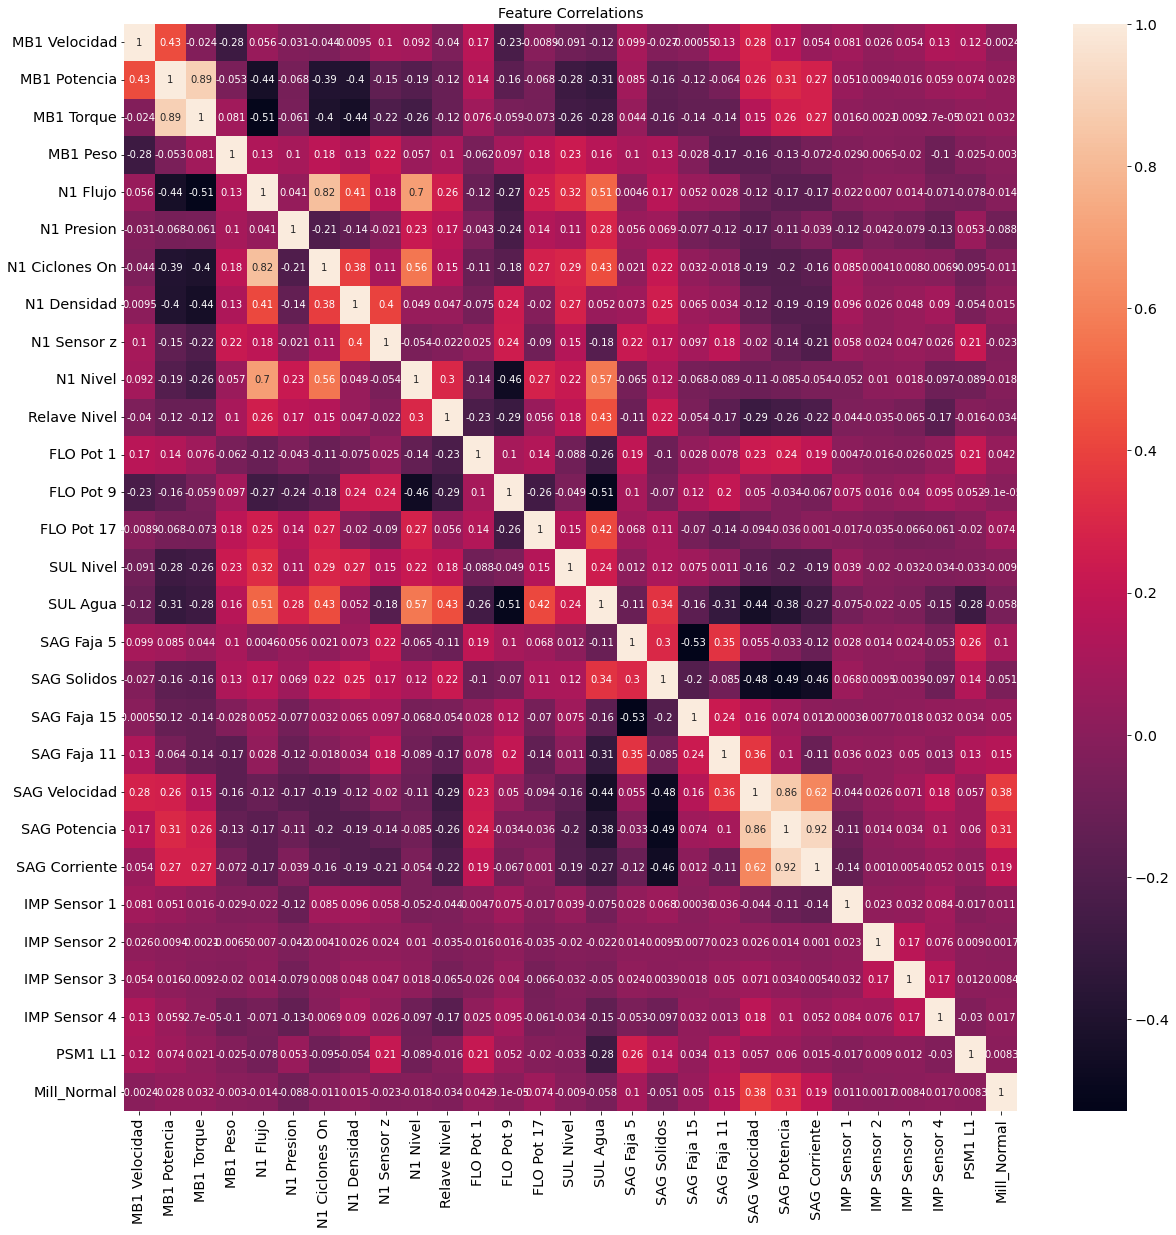

In [64]:
plot_corr(df_data,"Feature Correlations")

In [39]:
df_data.rename(columns={'Tiempo':'Timestamp'},inplace = True)

In [51]:
out_lst = detect_outliers(df_data,z_feats=["MB1 Velocidad"], skew_feats=['MB1 Potencia','MB1 Torque','MB1 Peso','N1 Flujo','N1 Presion','N1 Ciclones On','N1 Densidad','N1 Sensor z','N1 Nivel','Relave Nivel','FLO Pot 1','FLO Pot 9','FLO Pot 17','SUL Nivel','SUL Agua'])                        

df_outliers = pd.DataFrame(out_lst)
df_outliers

,Feature,Upper_Limit,Lower_Limit,Outier_N,Outlier_%
0,MB1 Velocidad,12.21,11.42,738,0.54
1,MB1 Potencia,16141.24,14661.23,9063,6.67
2,MB1 Torque,13021.92,11851.95,6705,4.93
3,MB1 Peso,2643.09,2293.69,4401,3.24
4,N1 Flujo,11018.59,5747.48,1885,1.39
5,N1 Presion,109.97,81.41,1028,0.76
6,N1 Ciclones On,11.50,7.50,578,0.43
7,N1 Densidad,1843.34,1619.37,1249,0.92
8,N1 Sensor z,51.59,42.44,7135,5.25
9,N1 Nivel,84.28,60.73,9956,7.32


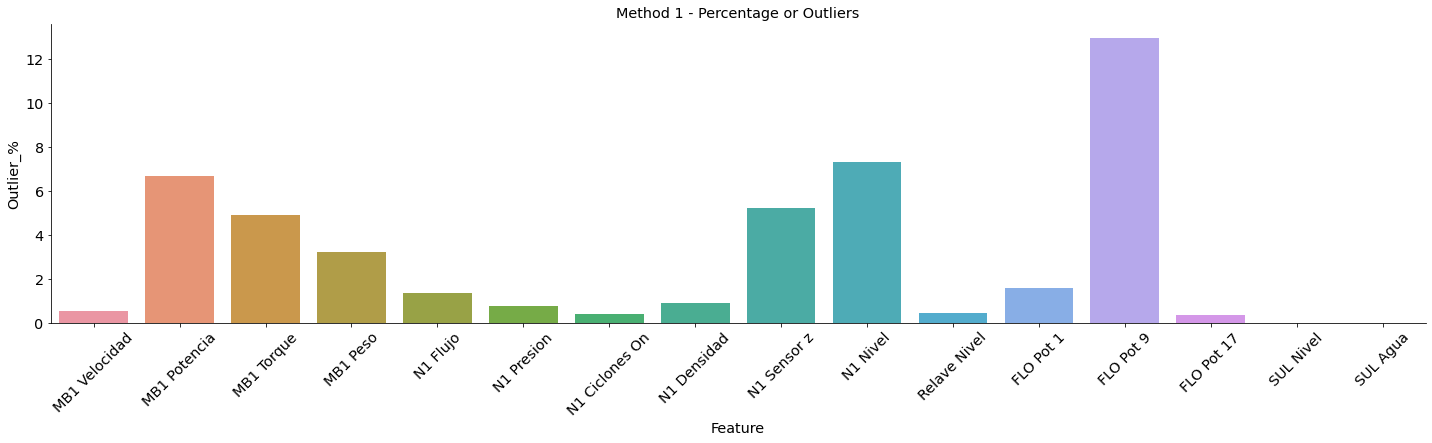

In [52]:
plot_cats(df_outliers,"Feature","Outlier_%","Method 1 - Percentage or Outliers")

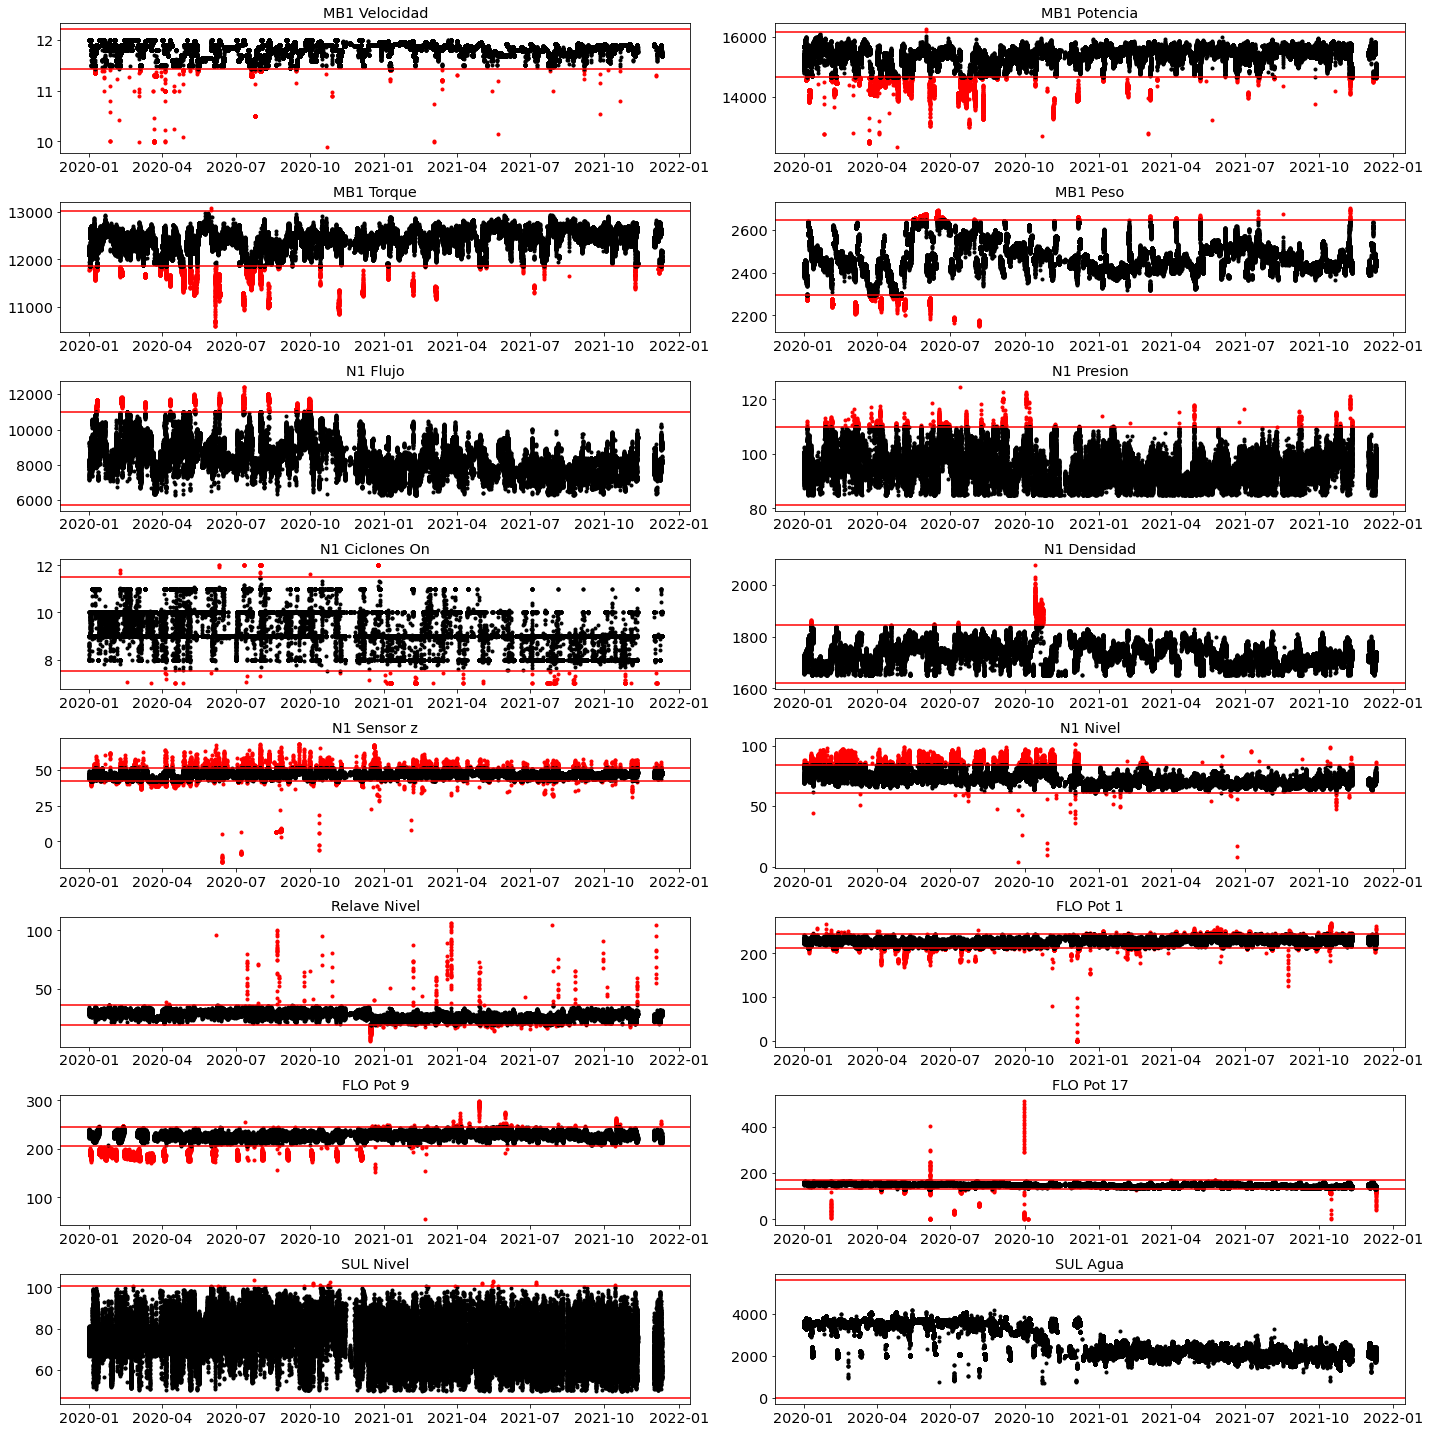

In [55]:
plot_outliers(df_data.drop(columns=['Mill_Normal','SAG Faja 5','SAG Solidos','SAG Faja 15','SAG Faja 11','SAG Velocidad','SAG Potencia','SAG Corriente','PSM1 L1','IMP Sensor 1','IMP Sensor 2','IMP Sensor 3','IMP Sensor 4']),df_out=df_outliers)

In [56]:
out_lst2 = detect_outliers(df_data,z_feats=["MB1 Velocidad"], skew_feats=['SAG Faja 5','SAG Solidos','SAG Faja 15','SAG Faja 11','SAG Velocidad','SAG Potencia','SAG Corriente','PSM1 L1','IMP Sensor 1','IMP Sensor 2','IMP Sensor 3','IMP Sensor 4'])                        

df_outliers2 = pd.DataFrame(out_lst2)
df_outliers2

,Feature,Upper_Limit,Lower_Limit,Outier_N,Outlier_%
0,MB1 Velocidad,12.21,11.42,738,0.54
1,SAG Faja 5,4851.83,3453.86,5141,3.78
2,SAG Solidos,81.71,66.43,36,0.03
3,SAG Faja 15,1265.57,-150.03,0,0.00
4,SAG Faja 11,756.99,276.11,3942,2.90
5,SAG Velocidad,10.00,7.92,3959,2.91
6,SAG Potencia,26414.44,17312.39,3319,2.44
7,SAG Corriente,4130.80,3144.07,2852,2.10
8,PSM1 L1,298.85,197.36,126,0.09
9,IMP Sensor 1,0.00,0.00,4474,3.29


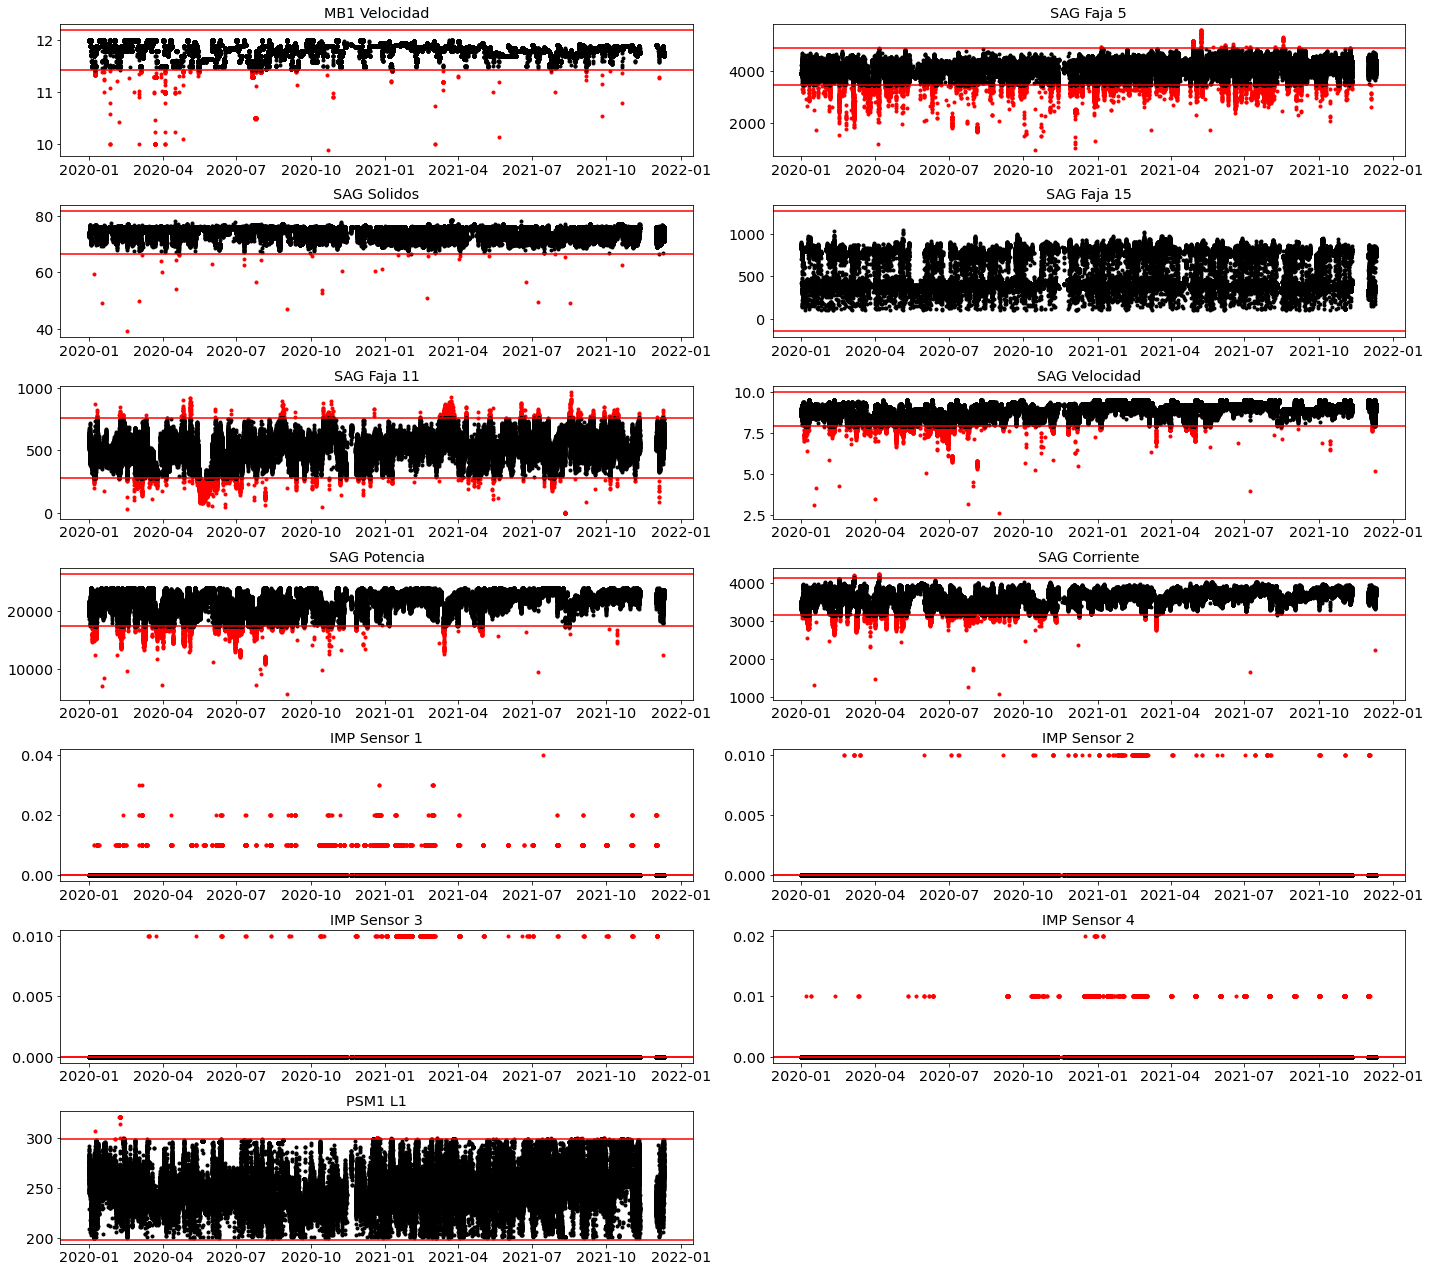

In [57]:
plot_outliers(df_data.drop(columns=['Mill_Normal','MB1 Potencia','MB1 Torque','MB1 Peso','N1 Flujo','N1 Presion','N1 Ciclones On','N1 Densidad','N1 Sensor z','N1 Nivel','Relave Nivel','FLO Pot 1','FLO Pot 9','FLO Pot 17','SUL Nivel','SUL Agua']),df_out=df_outliers2)

In [61]:
def plot_corr(df,title, fig_size=(20,20)):
    plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot = True)
    plt.title(title);

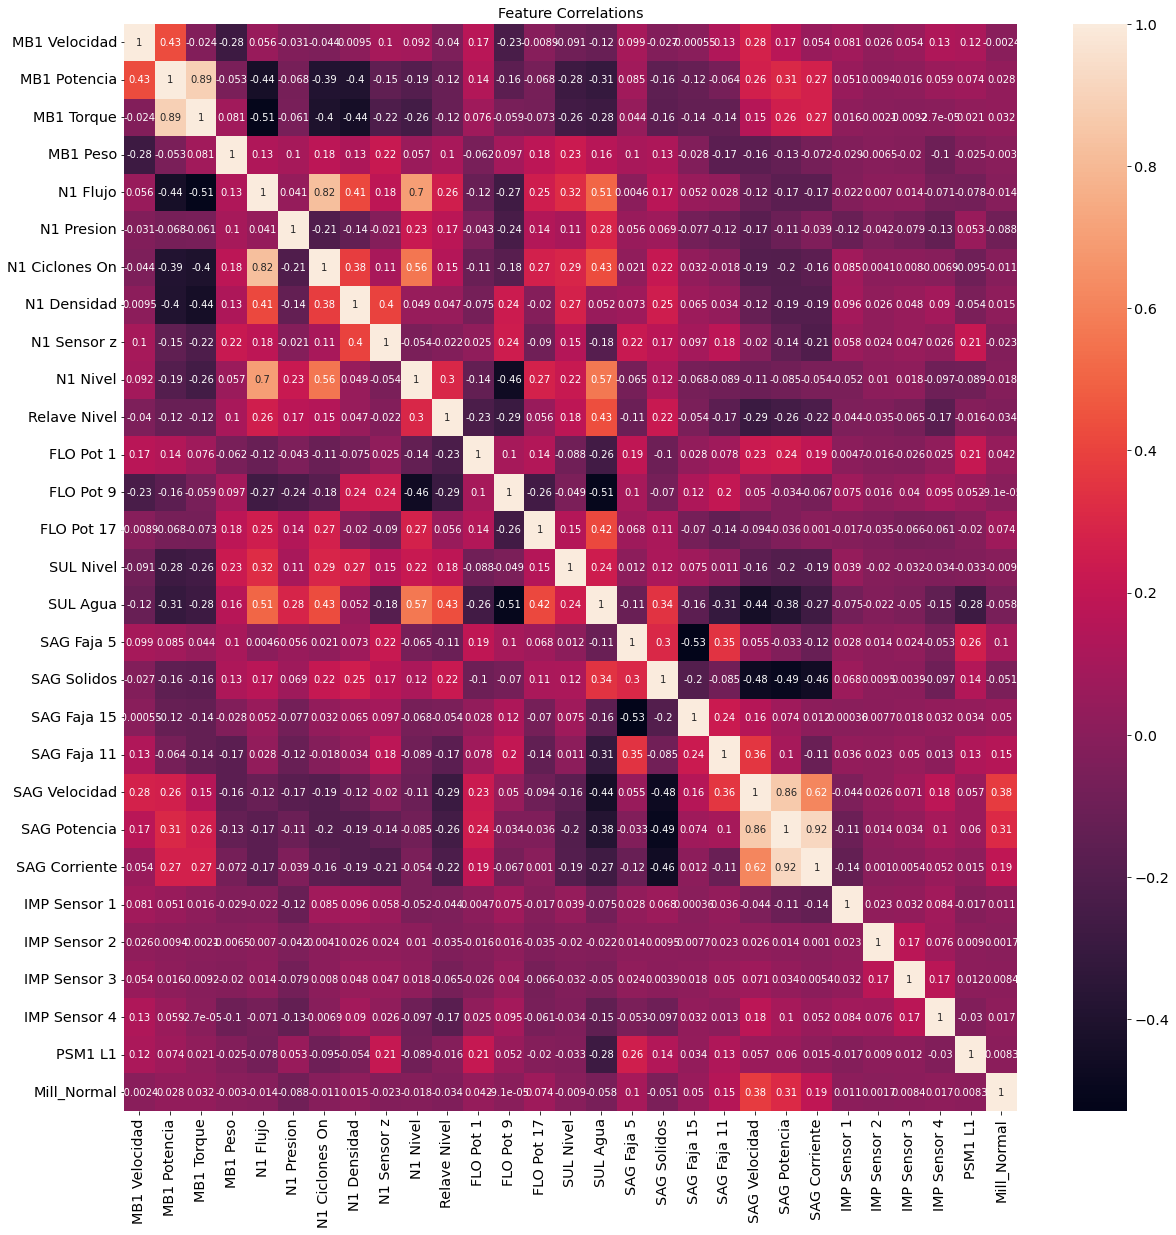

In [62]:
plot_corr(df_data,"Feature Correlations")